**Import các thư viện cần thiết**

In [ ]:
import os
import numpy as np
from pathlib import Path
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.utils import to_categorical, img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, MaxPool2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, ZeroPadding2D
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
import matplotlib.pyplot as plt

**Chuẩn bị dữ liệu**

In [ ]:
BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/Data"
TRAIN_PATH = 'Train'
VALID_PATH = 'Valid'
TEST_PATH = 'Test'
CLASSES = ['Eraser', 'Pen', 'Pencil_Sharpener', 'Ruler', 'Stapler']
IMG_SIZE = (224,224)
train_dataset = image_dataset_from_directory(
 Path.cwd() / BASE_PATH / TRAIN_PATH ,
 image_size=(224, 224),
 batch_size=32,
 label_mode='categorical')
validation_dataset = image_dataset_from_directory(
 Path.cwd() / BASE_PATH / VALID_PATH ,
 image_size=(224, 224),
 batch_size=32,
 label_mode='categorical')
test_dataset = image_dataset_from_directory(
 Path.cwd() / BASE_PATH / TEST_PATH ,
 image_size=(224, 224),
 batch_size=32,
 label_mode='categorical')

Found 1841 files belonging to 5 classes.
Found 373 files belonging to 5 classes.
Found 496 files belonging to 5 classes.


**Mô hình MLP**

In [ ]:
def MLP():
    inputs = Input(shape=(224, 224, 3))
    x = Flatten()(inputs)
    x = Dense(units=256, activation='relu')(x)
    x = Dense(units=128, activation='relu')(x)
    outputs = Dense(units=5, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Tạo model
model = MLP()
print(model.summary())

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 flatten_4 (Flatten)         (None, 150528)            0         
                                                                 
 dense_14 (Dense)            (None, 256)               38535424  
                                                                 
 dense_15 (Dense)            (None, 128)               32896     
                                                                 
 dense_16 (Dense)            (None, 5)                 645       
                                                                 
Total params: 38568965 (147.13 MB)
Trainable params: 38568965 (147.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# Compile mô hình
model.compile(loss="categorical_crossentropy",
 optimizer="adam",
 metrics=["accuracy"])
callbacks = [ ModelCheckpoint(
 filepath="mlp.keras",
 save_best_only=True,
 monitor="val_loss")
]
# train mô hình
H = model.fit(
 train_dataset,
 epochs=50,
 validation_data=validation_dataset,
 callbacks=callbacks)

Epoch 1/50
58/58 [==============================] - 28s 412ms/step - loss: 11404.6592 - accuracy: 0.2596 - val_loss: 2654.6516 - val_accuracy: 0.2413
Epoch 2/50
58/58 [==============================] - 27s 408ms/step - loss: 3143.3213 - accuracy: 0.3172 - val_loss: 2017.2068 - val_accuracy: 0.3485
Epoch 3/50
58/58 [==============================] - 26s 381ms/step - loss: 2787.2285 - accuracy: 0.3313 - val_loss: 3069.2202 - val_accuracy: 0.2413
Epoch 4/50
58/58 [==============================] - 24s 341ms/step - loss: 2277.4155 - accuracy: 0.3558 - val_loss: 2094.4185 - val_accuracy: 0.2922
Epoch 5/50
58/58 [==============================] - 24s 368ms/step - loss: 1828.6846 - accuracy: 0.3634 - val_loss: 4890.4629 - val_accuracy: 0.2359
Epoch 6/50
58/58 [==============================] - 27s 405ms/step - loss: 2275.4885 - accuracy: 0.3542 - val_loss: 1802.8212 - val_accuracy: 0.3405
Epoch 7/50
58/58 [==============================] - 27s 406ms/step - loss: 1760.4315 - accuracy: 0.3580 -

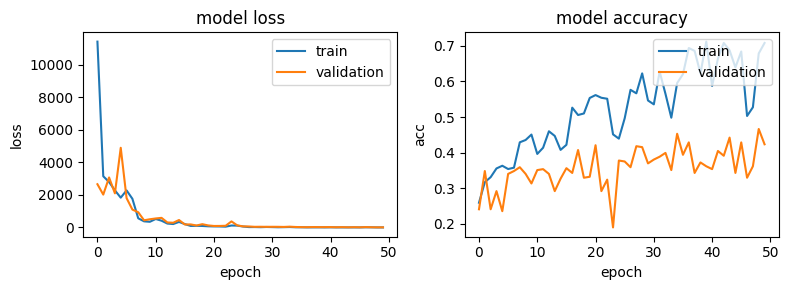

In [ ]:
train_loss, val_loss = H.history['loss'], H.history['val_loss']
train_acc, val_acc = H.history['accuracy'], H.history['val_accuracy']
fig, axs = plt.subplots(figsize=(8,3), nrows=1, ncols=2)
num_epochs = np.arange(len(train_loss))
axs[0].plot(num_epochs, train_loss)
axs[0].plot(num_epochs, val_loss)
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].set_title('model loss')
axs[0].legend(['train', 'validation'], loc='upper right')
axs[1].plot(num_epochs, train_acc)
axs[1].plot(num_epochs, val_acc)
axs[1].set_ylabel('acc')
axs[1].set_xlabel('epoch')
axs[1].set_title('model accuracy')
axs[1].legend(['train', 'validation'], loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:
test_model = load_model("mlp.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

16/16 [==============================] - 2s 52ms/step - loss: 8.1099 - accuracy: 0.4536
Test accuracy: 0.454


**Mô hình CNN**

In [ ]:
def CNN():
 inputs = Input(shape=(224,224,3))
 x = Rescaling(1.0/255)(inputs)
 x = Conv2D(filters=32,kernel_size=(3,3), activation='relu')(x)
 x = MaxPooling2D(pool_size=(2,2))(x)

 x = Conv2D(filters=64,kernel_size=(3,3), activation='relu')(x)
 x = MaxPooling2D(pool_size=(2,2))(x)

 x = Conv2D(filters=128,kernel_size=(3,3), activation='relu')(x)
 x = MaxPooling2D(pool_size=(2,2))(x)

 x = Conv2D(filters=256,kernel_size=(3,3), activation='relu')(x)
 x = MaxPooling2D(pool_size=(2,2))(x)

 x = Conv2D(filters=512,kernel_size=(3,3), activation='relu')(x)
 x = MaxPooling2D(pool_size=(2,2))(x)

 x = Flatten()(x)

 outputs = Dense(units=5, activation='softmax')(x)
 model = Model(inputs = inputs, outputs=outputs)
 return model
# Tạo model
model = CNN()
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                        

In [ ]:
# Compile mô hình
model.compile(loss="categorical_crossentropy",
 optimizer="adam",
 metrics=["accuracy"])
callbacks = [ ModelCheckpoint(
 filepath="cnn.keras",
 save_best_only=True,
 monitor="val_loss")
]
# train mô hình
H = model.fit(
 train_dataset,
 epochs=50,
 validation_data=validation_dataset,
 callbacks=callbacks)

Epoch 1/50
58/58 [==============================] - 510s 8s/step - loss: 1.5520 - accuracy: 0.2944 - val_loss: 1.4615 - val_accuracy: 0.3753
Epoch 2/50
58/58 [==============================] - 24s 368ms/step - loss: 1.3511 - accuracy: 0.4454 - val_loss: 1.4250 - val_accuracy: 0.4048
Epoch 3/50
58/58 [==============================] - 24s 358ms/step - loss: 1.1368 - accuracy: 0.5464 - val_loss: 1.2182 - val_accuracy: 0.4933
Epoch 4/50
58/58 [==============================] - 25s 374ms/step - loss: 1.0073 - accuracy: 0.5921 - val_loss: 1.1690 - val_accuracy: 0.5308
Epoch 5/50
58/58 [==============================] - 25s 374ms/step - loss: 0.9132 - accuracy: 0.6317 - val_loss: 1.1437 - val_accuracy: 0.5201
Epoch 6/50
58/58 [==============================] - 23s 353ms/step - loss: 0.8137 - accuracy: 0.6936 - val_loss: 1.0728 - val_accuracy: 0.5684
Epoch 7/50
58/58 [==============================] - 24s 353ms/step - loss: 0.6476 - accuracy: 0.7550 - val_loss: 1.1058 - val_accuracy: 0.5898
E

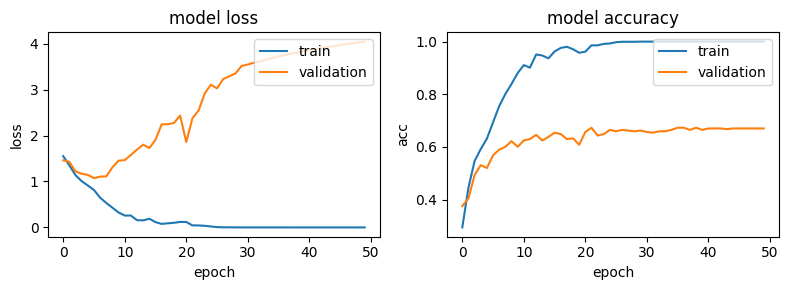

In [ ]:
train_loss, val_loss = H.history['loss'], H.history['val_loss']
train_acc, val_acc = H.history['accuracy'], H.history['val_accuracy']
fig, axs = plt.subplots(figsize=(8,3), nrows=1, ncols=2)
num_epochs = np.arange(len(train_loss))
axs[0].plot(num_epochs, train_loss)
axs[0].plot(num_epochs, val_loss)
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].set_title('model loss')
axs[0].legend(['train', 'validation'], loc='upper right')
axs[1].plot(num_epochs, train_acc)
axs[1].plot(num_epochs, val_acc)
axs[1].set_ylabel('acc')
axs[1].set_xlabel('epoch')
axs[1].set_title('model accuracy')
axs[1].legend(['train', 'validation'], loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:
test_model = load_model("cnn.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

16/16 [==============================] - 122s 3s/step - loss: 1.1024 - accuracy: 0.6008
Test accuracy: 0.601


**Mô hình ResNet**

In [ ]:
def identity_block(X, filters):
  F1, F2, F3 = filters

  shortcut = X
  # 1 Convolution 1x1
  X = Conv2D(filters=F1, kernel_size=(1,1), strides=(1,1), padding='valid')(X)
  X = BatchNormalization(axis = 3)(X)
  X = Activation('relu')(X)
  # 2 Convolution 3x3
  X = Conv2D(filters=F2, kernel_size=(3,3), strides=(1,1), padding='same')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  # 3 Convolution 1x1
  X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding='valid')(X)
  X = BatchNormalization(axis = 3)(X)
  # 4 shortcut
  X = Add()([shortcut,X])
  X = Activation('relu')(X)
  return X

In [ ]:
input_shape = (32,32,16)
input = Input(shape = input_shape)
output = identity_block(input, filters=[16,16,16])
model = Model(inputs=input, outputs=output)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 16)]         0         []                            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 32, 32, 16)           272       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 16)           64        ['conv2d_5[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 32, 32, 16)           0         ['batch_normalization[0]

In [ ]:
def convolutional_block(X, filters, s=2):
 F1, F2, F3 = filters

 # Lưu giá trị Input (tạo shortcut)
 shortcut = X
 # 1. Convolution 1x1
 X = Conv2D(filters=F1, kernel_size=(1,1), strides=(s,s), padding='valid')(X)
 X = BatchNormalization(axis=3)(X)
 X = Activation('relu')(X)
 # 2. Convolution 3x3
 X = Conv2D(filters=F2, kernel_size=(3,3),strides=(1,1), padding='same')(X)
 X = BatchNormalization(axis=3)(X)
 X = Activation('relu')(X)
 # 3. Convolution 1x1
 X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding='valid')(X)
 X = BatchNormalization(axis=3)(X)
 # 4. Convolutional shortcut
 shortcut = Conv2D(filters=F3, kernel_size=(1,1), strides=(s,s), padding='valid')(shortcut)
 shortcut = BatchNormalization(axis=3)(shortcut)
 # 5. Shortcut
 X = Add()([X, shortcut])
 X = Activation('relu')(X)
 return X

In [ ]:
input = Input(shape=(32,32,16))
output = convolutional_block(input, filters=[16,16,16])
model = Model(inputs=input, outputs=output)
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 16)]         0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 16, 16, 16)           272       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_3 (Bat  (None, 16, 16, 16)           64        ['conv2d_8[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_3 (Activation)   (None, 16, 16, 16)           0         ['batch_normalization_3[

In [ ]:
def ResNet50(input_shape=(224, 224, 3), classes=5):
 input = Input(input_shape)
 # Zero-Padding
 X = ZeroPadding2D((3, 3))(input)
 # Stage 1
 X = Conv2D(64, (7,7), strides=(2,2))(X)
 X = BatchNormalization(axis=3)(X)
 X = Activation('relu')(X)
 X = MaxPooling2D((3,3), strides=(2,2))(X)
 # Stage 2
 X = convolutional_block(X, filters=[64,64,256], s=1)
 X = identity_block(X, filters=[64,64,256])
 X = identity_block(X, filters=[64,64,256])
 # Stage 3
 X = convolutional_block(X, filters=[128,128,512], s=2)
 X = identity_block(X, filters=[128,128,512])
 X = identity_block(X, filters=[128,128,512])
 X = identity_block(X, filters=[128,128,512])
 # Stage 4
 X = convolutional_block(X, filters=[256,256,1024], s=2)
 X = identity_block(X, filters=[256, 256, 1024])
 X = identity_block(X, filters=[256, 256, 1024])
 X = identity_block(X, filters=[256, 256, 1024])
 X = identity_block(X, filters=[256, 256, 1024])
 X = identity_block(X, filters=[256, 256, 1024])
 # Stage 5
 X = convolutional_block(X, filters=[512,512,2048], s=2)
 X = identity_block(X, filters=[512,512,2048])
 X = identity_block(X, filters=[512,512,2048])
 X = GlobalAveragePooling2D()(X)
 # output layer
 X = Flatten()(X)
 X = Dense(classes, activation='softmax')(X)
 # Tạo model
 model = Model(inputs=input, outputs=X)
 return model
model = ResNet50()
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_4[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d_12 (Conv2D)          (None, 112, 112, 64)         9472      ['zero_padding2d[0][0]']      
                                                                                                  
 batch_normalization_7 (Bat  (None, 112, 112, 64)         256       ['conv2d_12[0][0]']     

In [ ]:
# Compile mô hình
model.compile(loss="categorical_crossentropy",
 optimizer="adam",
 metrics=["accuracy"])
callbacks = [ ModelCheckpoint(
 filepath="resnet.keras",
 save_best_only=True,
 monitor="val_loss")
]
# train mô hình
H = model.fit(
 train_dataset,
 epochs=50,
 validation_data=validation_dataset,
 callbacks=callbacks)

Epoch 1/50
58/58 [==============================] - 77s 633ms/step - loss: 2.0234 - accuracy: 0.3851 - val_loss: 9.4220 - val_accuracy: 0.2279
Epoch 2/50
58/58 [==============================] - 34s 514ms/step - loss: 1.5357 - accuracy: 0.4188 - val_loss: 2.1810 - val_accuracy: 0.3164
Epoch 3/50
58/58 [==============================] - 35s 540ms/step - loss: 1.4763 - accuracy: 0.4237 - val_loss: 1.9626 - val_accuracy: 0.3110
Epoch 4/50
58/58 [==============================] - 32s 494ms/step - loss: 1.3150 - accuracy: 0.4861 - val_loss: 2.0994 - val_accuracy: 0.3619
Epoch 5/50
58/58 [==============================] - 32s 493ms/step - loss: 1.3531 - accuracy: 0.4541 - val_loss: 27.3336 - val_accuracy: 0.2708
Epoch 6/50
58/58 [==============================] - 33s 498ms/step - loss: 1.3217 - accuracy: 0.4764 - val_loss: 3.3668 - val_accuracy: 0.3029
Epoch 7/50
58/58 [==============================] - 32s 495ms/step - loss: 1.2593 - accuracy: 0.4976 - val_loss: 52.9983 - val_accuracy: 0.30

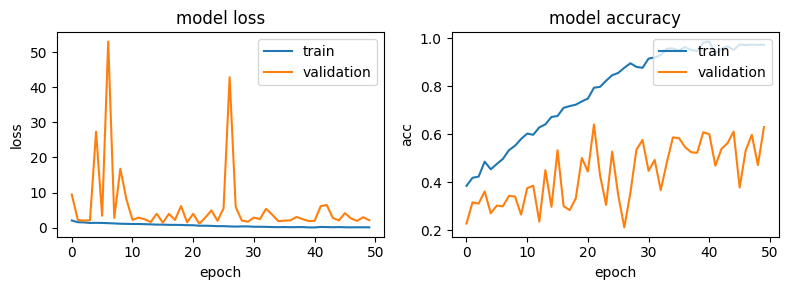

In [ ]:
train_loss, val_loss = H.history['loss'], H.history['val_loss']
train_acc, val_acc = H.history['accuracy'], H.history['val_accuracy']
fig, axs = plt.subplots(figsize=(8,3), nrows=1, ncols=2)
num_epochs = np.arange(len(train_loss))
axs[0].plot(num_epochs, train_loss)
axs[0].plot(num_epochs, val_loss)
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].set_title('model loss')
axs[0].legend(['train', 'validation'], loc='upper right')
axs[1].plot(num_epochs, train_acc)
axs[1].plot(num_epochs, val_acc)
axs[1].set_ylabel('acc')
axs[1].set_xlabel('epoch')
axs[1].set_title('model accuracy')
axs[1].legend(['train', 'validation'], loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:
test_model = load_model("resnet.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

16/16 [==============================] - 6s 198ms/step - loss: 1.1695 - accuracy: 0.6048
Test accuracy: 0.605


**Mô hình Resnet Transfer Learning**

In [ ]:
from keras.applications import ResNet50
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout
from keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, Rescaling
from keras.applications.resnet50 import preprocess_input

def ResNet50_FeatureExtraction():
    data_augmentation = Sequential(
        [
            RandomFlip("horizontal"),
            RandomRotation(0.1),
            RandomZoom(0.2),
        ]
    )

    # Load mô hình ResNet50
    conv_base = ResNet50(weights='imagenet', include_top=False)
    # Đóng băng các tầng conv
    conv_base.trainable = False
    inputs = Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = conv_base(x)
    # Thêm tầng Dense và Dropout
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(units=5, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model
model = ResNet50_FeatureExtraction()
print(model.summary())

94765736/94765736 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                

In [ ]:
# Compile mô hình
model.compile(loss="categorical_crossentropy",
 optimizer="adam",
 metrics=["accuracy"])
callbacks = [ ModelCheckpoint(
 filepath="feature_extraction.h5",
 save_best_only=True,
 monitor="val_loss")
]
# train mô hình
H = model.fit(
 train_dataset,
 epochs=50,
 validation_data=validation_dataset,
 callbacks=callbacks)

Epoch 1/50
58/58 [==============================] - ETA: 0s - loss: 5.1193 - accuracy: 0.7990 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - 777s 13s/step - loss: 5.1193 - accuracy: 0.7990 - val_loss: 0.2970 - val_accuracy: 0.9544
Epoch 2/50
58/58 [==============================] - 27s 413ms/step - loss: 0.7798 - accuracy: 0.9098 - val_loss: 0.5049 - val_accuracy: 0.9517
Epoch 3/50
58/58 [==============================] - 28s 437ms/step - loss: 0.4874 - accuracy: 0.9240 - val_loss: 0.1654 - val_accuracy: 0.9651
Epoch 4/50
58/58 [==============================] - 27s 416ms/step - loss: 0.2380 - accuracy: 0.9267 - val_loss: 0.1655 - val_accuracy: 0.9571
Epoch 5/50
58/58 [==============================] - 27s 416ms/step - loss: 0.3831 - accuracy: 0.9202 - val_loss: 0.1817 - val_accuracy: 0.9598
Epoch 6/50
58/58 [==============================] - 29s 454ms/step - loss: 0.2710 - accuracy: 0.9337 - val_loss: 0.1363 - val_accuracy: 0.9678
Epoch 7/50
58/58 [==============================] - 29s 436ms/step - loss: 0.3139 - accuracy: 0.9359 - val_loss: 0.0708 - val_accuracy: 0.9812
Epoch 8/50


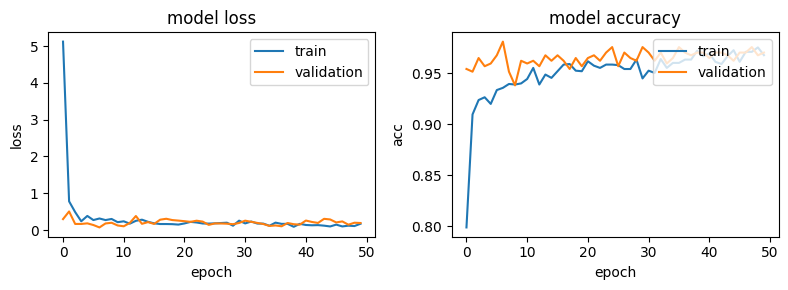

In [ ]:
train_loss, val_loss = H.history['loss'], H.history['val_loss']
train_acc, val_acc = H.history['accuracy'], H.history['val_accuracy']
fig, axs = plt.subplots(figsize=(8,3), nrows=1, ncols=2)
num_epochs = np.arange(len(train_loss))
axs[0].plot(num_epochs, train_loss)
axs[0].plot(num_epochs, val_loss)
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].set_title('model loss')
axs[0].legend(['train', 'validation'], loc='upper right')
axs[1].plot(num_epochs, train_acc)
axs[1].plot(num_epochs, val_acc)
axs[1].set_ylabel('acc')
axs[1].set_xlabel('epoch')
axs[1].set_title('model accuracy')
axs[1].legend(['train', 'validation'], loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:
test_model = load_model("feature_extraction.h5")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

16/16 [==============================] - 206s 6s/step - loss: 0.2835 - accuracy: 0.9637
Test accuracy: 0.964


**Mô hình VGG16**

In [ ]:
def VGG():
  model = Sequential()
  # Khối VGG 1
  model.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same', activation='relu', input_shape=(224,224,3), name='conv2d'))
  model.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same', activation='relu', name='conv2d_1'))
  model.add(MaxPool2D(pool_size=(2,2), strides=2, name='max_pooling2d'))

  # Khối VGG 2
  model.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='same', activation='relu', name='conv2d_2'))
  model.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='same', activation='relu', name='conv2d_3'))
  model.add(MaxPool2D(pool_size=(2,2), strides=2, name='max_pooling2d_1'))

  # Khối VGG 3
  model.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='same', activation='relu', name='conv2d_4'))
  model.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='same', activation='relu', name='conv2d_5'))
  model.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='same', activation='relu', name='conv2d_6'))
  model.add(MaxPool2D(pool_size=(2,2), strides=2, name='max_pooling2d_2'))

  # Khối VGG 4
  model.add(Conv2D(filters=512, kernel_size=(3,3), strides=1, padding='same', activation='relu', name='conv2d_7'))
  model.add(Conv2D(filters=512, kernel_size=(3,3), strides=1, padding='same', activation='relu', name='conv2d_8'))
  model.add(Conv2D(filters=512, kernel_size=(3,3), strides=1, padding='same', activation='relu', name='conv2d_9'))
  model.add(MaxPool2D(pool_size=(2,2), strides=2, name='max_pooling2d_3'))

  # Khối VGG 1
  model.add(Conv2D(filters=512, kernel_size=(3,3), strides=1, padding='same', activation='relu', name='conv2d_10'))
  model.add(Conv2D(filters=512, kernel_size=(3,3), strides=1, padding='same', activation='relu', name='conv2d_11'))
  model.add(Conv2D(filters=512, kernel_size=(3,3), strides=1, padding='same', activation='relu', name='conv2d_12'))
  model.add(MaxPool2D(pool_size=(2,2), strides=2, name='max_pooling2d_4'))

  # fully connected layer
  model.add(Flatten(name='flatten'))

  model.add(Dense(units=4096, activation='relu', name='dense'))
  model.add(Dropout(0.5))

  model.add(Dense(units=4096, activation='relu', name='dense_1'))
  model.add(Dropout(0.5))

  model.add(Dense(units=5, activation='softmax', name='dense_2'))

  return model
model = VGG()
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                 

In [ ]:
# Compile mô hình
model.compile(loss="categorical_crossentropy",
 optimizer="adam",
 metrics=["accuracy"])
callbacks = [ ModelCheckpoint(
 filepath="vgg16.h5",
 save_best_only=True,
 monitor="val_loss")
]
# train mô hình
H = model.fit(
 train_dataset,
 epochs=50,
 validation_data=validation_dataset,
 callbacks=callbacks)

Epoch 1/50
58/58 [==============================] - ETA: 0s - loss: 61.3899 - accuracy: 0.2232

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - 432s 7s/step - loss: 61.3899 - accuracy: 0.2232 - val_loss: 1.5843 - val_accuracy: 0.2547
Epoch 2/50
58/58 [==============================] - 41s 662ms/step - loss: 1.5950 - accuracy: 0.2412 - val_loss: 1.5822 - val_accuracy: 0.2547
Epoch 3/50
58/58 [==============================] - 34s 530ms/step - loss: 1.5945 - accuracy: 0.2450 - val_loss: 1.5836 - val_accuracy: 0.2547
Epoch 4/50
58/58 [==============================] - 34s 519ms/step - loss: 1.5937 - accuracy: 0.2352 - val_loss: 1.5829 - val_accuracy: 0.2547
Epoch 5/50
58/58 [==============================] - 42s 684ms/step - loss: 1.5933 - accuracy: 0.2303 - val_loss: 1.5820 - val_accuracy: 0.2547
Epoch 6/50
58/58 [==============================] - 52s 845ms/step - loss: 1.5939 - accuracy: 0.2450 - val_loss: 1.5820 - val_accuracy: 0.2547
Epoch 7/50
58/58 [==============================] - 36s 583ms/step - loss: 1.5922 - accuracy: 0.2488 - val_loss: 1.5828 - val_accuracy: 0.2547
Epoch 8/50


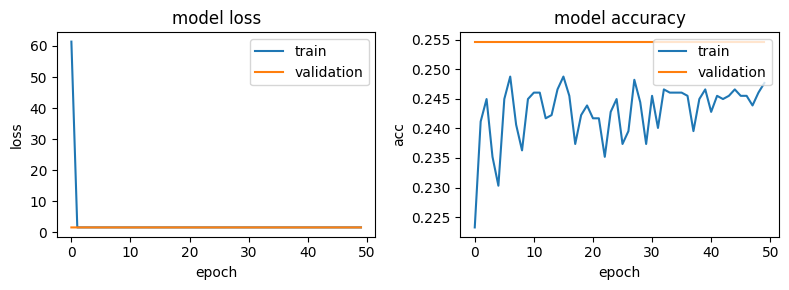

In [ ]:
train_loss, val_loss = H.history['loss'], H.history['val_loss']
train_acc, val_acc = H.history['accuracy'], H.history['val_accuracy']
fig, axs = plt.subplots(figsize=(8,3), nrows=1, ncols=2)
num_epochs = np.arange(len(train_loss))
axs[0].plot(num_epochs, train_loss)
axs[0].plot(num_epochs, val_loss)
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].set_title('model loss')
axs[0].legend(['train', 'validation'], loc='upper right')
axs[1].plot(num_epochs, train_acc)
axs[1].plot(num_epochs, val_acc)
axs[1].set_ylabel('acc')
axs[1].set_xlabel('epoch')
axs[1].set_title('model accuracy')
axs[1].legend(['train', 'validation'], loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:
test_model = load_model("vgg16.h5")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

16/16 [==============================] - 3s 125ms/step - loss: 1.5837 - accuracy: 0.2520
Test accuracy: 0.252


**Mô hình VGG16 Transfer Learning**

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, Rescaling
def VGG_FeatureExtraction():
 # Tầng sinh dữ liệu
 data_augmentation = Sequential(
 [
 RandomFlip("horizontal"),
 RandomRotation(0.1),
 RandomZoom(0.2),
 ]
 )
 # Load mô hình VGG16
 conv_base = VGG16(weights='imagenet', input_shape=(224,224,3),include_top=False)
 # Đóng băng các tầng conv
 conv_base.trainable=False
 inputs = Input(shape=(224, 224, 3))
 x = data_augmentation(inputs)
 x = preprocess_input(x)
 x = conv_base(x)
 x = Flatten()(x)
 x = Dense(256, activation='relu')(x)
 x = Dropout(0.5)(x)
 outputs = Dense(units=5, activation='softmax')(x)
 model = Model(inputs, outputs)
 return model
# Tạo model
model = VGG_FeatureExtraction()
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_7 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0   

In [ ]:
# Compile mô hình
model.compile(loss="categorical_crossentropy",
 optimizer="adam",
 metrics=["accuracy"])
callbacks = [ ModelCheckpoint(
 filepath="vgg16_transfer.h5",
 save_best_only=True,
 monitor="val_loss")
]
# train mô hình
H = model.fit(
 train_dataset,
 epochs=50,
 validation_data=validation_dataset,
 callbacks=callbacks)

Epoch 1/50
58/58 [==============================] - 30s 438ms/step - loss: 4.9968 - accuracy: 0.8001 - val_loss: 0.9647 - val_accuracy: 0.9571
Epoch 2/50
58/58 [==============================] - 28s 438ms/step - loss: 1.7066 - accuracy: 0.9011 - val_loss: 0.6141 - val_accuracy: 0.9357
Epoch 3/50
58/58 [==============================] - 28s 443ms/step - loss: 0.7039 - accuracy: 0.9022 - val_loss: 0.3696 - val_accuracy: 0.9491
Epoch 4/50
58/58 [==============================] - 28s 440ms/step - loss: 0.6563 - accuracy: 0.9044 - val_loss: 0.2920 - val_accuracy: 0.9571
Epoch 5/50
58/58 [==============================] - 30s 463ms/step - loss: 0.5609 - accuracy: 0.9142 - val_loss: 0.2008 - val_accuracy: 0.9517
Epoch 6/50
58/58 [==============================] - 27s 427ms/step - loss: 0.4342 - accuracy: 0.9294 - val_loss: 0.2242 - val_accuracy: 0.9303
Epoch 7/50
58/58 [==============================] - 27s 431ms/step - loss: 0.4410 - accuracy: 0.9191 - val_loss: 0.2924 - val_accuracy: 0.9437

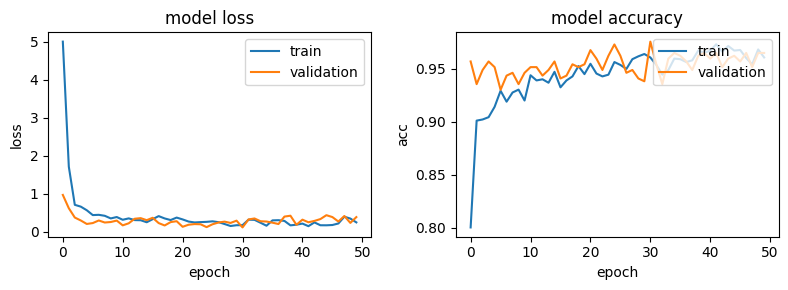

In [ ]:
train_loss, val_loss = H.history['loss'], H.history['val_loss']
train_acc, val_acc = H.history['accuracy'], H.history['val_accuracy']
fig, axs = plt.subplots(figsize=(8,3), nrows=1, ncols=2)
num_epochs = np.arange(len(train_loss))
axs[0].plot(num_epochs, train_loss)
axs[0].plot(num_epochs, val_loss)
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].set_title('model loss')
axs[0].legend(['train', 'validation'], loc='upper right')
axs[1].plot(num_epochs, train_acc)
axs[1].plot(num_epochs, val_acc)
axs[1].set_ylabel('acc')
axs[1].set_xlabel('epoch')
axs[1].set_title('model accuracy')
axs[1].legend(['train', 'validation'], loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:
test_model = load_model("vgg16_transfer.h5")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

16/16 [==============================] - 98s 3s/step - loss: 0.4964 - accuracy: 0.9476
Test accuracy: 0.948
